<a href="https://colab.research.google.com/github/DaganItay/ItayDagan-projects/blob/main/HP_Orders_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import files
# Upload the Excel file
#uploaded = files.upload()
#file_path = list(uploaded.keys())[0]

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from sklearn.metrics import confusion_matrix

from joblib import dump, load

In [15]:
n_of_programs_rows=0
programs_to_delete=["NaN"]

df=pd.read_excel('forTrain.xlsx',sheet_name='forTrain')
category_counts =df['Programs'].value_counts()

# Filter out categories with less than n occurrences
categories_to_keep = category_counts[(category_counts >= n_of_programs_rows) & (~category_counts.index.isin(programs_to_delete))].index
df = df[df['Programs'].isin(categories_to_keep)]

df['Programs'].value_counts()

Programs
Kedem                       5860
Barak                       5206
Yael                        1661
HP Indigo WS6X00            1028
Ayala                        791
Hilla                        601
David                        430
Shani                        335
Tamar                        299
YMCK                         253
HP Indigo 30000              216
Blonde                       213
Ser 2,3 Products             169
HP Indigo 7X00               159
PrintOS Press                130
Technology roadmap/NBA        97
HP Indigo 10000               86
Special Inks                  59
HP Indigo 8000                52
SAP & Finishing               50
Ella                          44
HP Indigo 5x000 + 20000c      43
Levana                        40
Applications development      36
Ser 4                         33
Security                      21
DFE Programs                  20
Hoshen                        18
Dune                          17
HP Indigo W72x0               10
G

In [16]:
column_types = {col: 'str' for col in df.columns if col != 'amount'}
column_types['amount'] = 'float'
df = df.astype(column_types)
df['CombinedText'] = df['Detail Comments'] + ' ' + df['PO Description'] + ' ' + df['Item Description']
df=df.drop(['Detail Comments','PO Description','Item Description'],axis=1)
label_encoder = LabelEncoder()
df['Programs'] = label_encoder.fit_transform(df['Programs'])

In [17]:
import warnings

warnings.filterwarnings("ignore", message=".*implicit conversion.*")  # Example pattern


# Split data into features (X) and target variable (y)
X = df.drop('Programs', axis=1)
y = df['Programs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40, shuffle=True, stratify=y)

# Define preprocessing for text, categorical, and numerical columns
#text_preprocessor = ('text', TfidfVectorizer(stop_words='english'), 'CombinedText')
#numeric_preprocessor = ('numeric', StandardScaler(), ['amount'])
text_preprocessor = ('text', TfidfVectorizer(stop_words='english', max_df=0.8), 'CombinedText')
categorical_preprocessor = ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Cost_Center_Calc','Requester','Item','Supplier Name','GL Account'])
numeric_preprocessor = ('numeric', SimpleImputer(strategy='constant', fill_value=0), ['amount','Year T','Quarter_'])

# Define column transformer to apply preprocessing to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        text_preprocessor,
        categorical_preprocessor,
        numeric_preprocessor
    ],
    remainder='drop'  # Drop any columns not specified in transformers
)

# model = XGBClassifier(
#         n_estimators=1000,
#         learning_rate=0.1,
#         max_depth=5)

#model = XGBClassifier(tree_method='gpu_hist')
model = XGBClassifier()


# Create a pipeline to combine preprocessing and modeling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8500889679715302


In [ ]:
# import pickle
# import os
# from google.colab import files

# # Assuming 'model' is your trained XGBoost model
# model_path = '/content/drive/MyDrive/Itay General/Control - Machine learning/xgboost_model.pkl'

# # Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(model_path), exist_ok=True)

# with open(model_path, 'wb') as model_file:
#     pickle.dump(model, model_file)
# files.download(model_path)

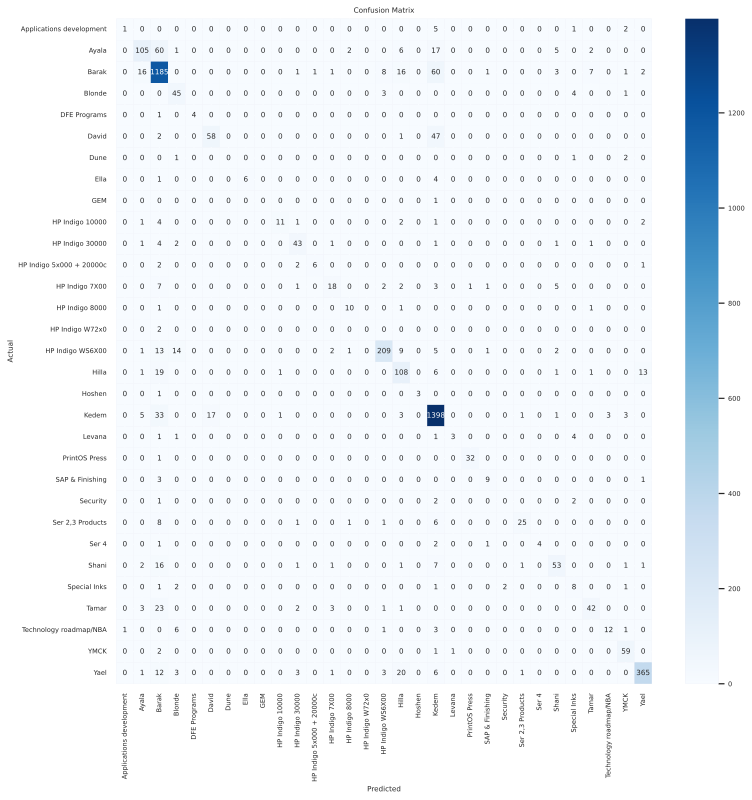

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.set(font_scale=0.6)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
# Calculate accuracy for each label
y_test_t=label_encoder.inverse_transform(y_test)
y_pred_t=label_encoder.inverse_transform(y_pred)
accuracy_per_label = pd.DataFrame({'y_test': y_test_t, 'y_pred': y_pred_t})
accuracy_per_label['correct'] = accuracy_per_label['y_test'] == accuracy_per_label['y_pred']
accuracy_per_label = accuracy_per_label.groupby('y_test')['correct'].agg(['mean', 'count'])
accuracy_per_label['mean'] *= 100
accuracy_per_label = accuracy_per_label.sort_values(by='count', ascending=False)

# Display the results in a table format
print("Accuracy per label:")
print(accuracy_per_label)


Accuracy per label:
                               mean  count
y_test                                    
Kedem                     95.426621   1465
Barak                     91.013825   1302
Yael                      87.951807    415
HP Indigo WS6X00          81.322957    257
Ayala                     53.030303    198
Hilla                     72.000000    150
David                     53.703704    108
Shani                     63.095238     84
Tamar                     56.000000     75
YMCK                      93.650794     63
HP Indigo 30000           79.629630     54
Blonde                    84.905660     53
Ser 2,3 Products          59.523810     42
HP Indigo 7X00            45.000000     40
PrintOS Press             96.969697     33
Technology roadmap/NBA    50.000000     24
HP Indigo 10000           50.000000     22
Special Inks              53.333333     15
SAP & Finishing           69.230769     13
HP Indigo 8000            76.923077     13
HP Indigo 5x000 + 20000c  54.54545

In [20]:
y_pred_probabilities = pipeline.predict_proba(X_test)

incorrectly_classified_indices = y_pred == y_test

# Extract the probabilities for instances where the model was incorrect
incorrect_probabilities = y_pred_probabilities[incorrectly_classified_indices]
sorted_array = np.sort(incorrect_probabilities[4])[::-1]

# Set the print options for this specific array
np.set_printoptions(precision=2, suppress=True)
formatted_str = np.array2string(sorted_array)

print(formatted_str)


[0.97 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


In [21]:
# Extract the probabilities for instances where the model was incorrect
incorrect_probabilities = y_pred_probabilities[incorrectly_classified_indices]
sorted_array = np.sort(incorrect_probabilities[3])[::-1]

# Set the print options for this specific array
np.set_printoptions(precision=2, suppress=True)
formatted_str = np.array2string(sorted_array)

print(formatted_str)


[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


In [22]:
# Extract the probabilities for instances where the model was incorrect
incorrect_probabilities = y_pred_probabilities[incorrectly_classified_indices]
sorted_array = np.sort(incorrect_probabilities[20])[::-1]

# Set the print options for this specific array
np.set_printoptions(precision=2, suppress=True)
formatted_str = np.array2string(sorted_array)

print(formatted_str)

[0.51 0.47 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


Overall Accuracy: 0.8501


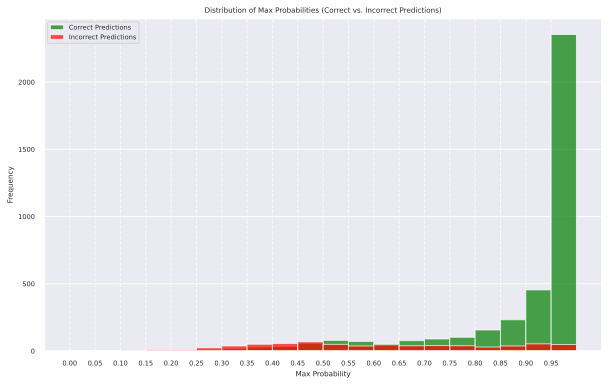

 Bin Range   Total Count  % of Total Count  % Correct
0.00 - 0.05        0          0.000000           NaN 
0.05 - 0.10        0          0.000000           NaN 
0.10 - 0.15        3          0.066726     33.333333 
0.15 - 0.20       16          0.355872     31.250000 
0.20 - 0.25       14          0.311388     21.428571 
0.25 - 0.30       32          0.711744     28.125000 
0.30 - 0.35       55          1.223310     32.727273 
0.35 - 0.40       80          1.779359     37.500000 
0.40 - 0.45       88          1.957295     37.500000 
0.45 - 0.50      125          2.780249     45.600000 
0.50 - 0.55      128          2.846975     61.718750 
0.55 - 0.60      108          2.402135     65.740741 
0.60 - 0.65       98          2.179715     53.061224 
0.65 - 0.70      116          2.580071     66.379310 
0.70 - 0.75      129          2.869217     68.992248 
0.75 - 0.80      141          3.136121     72.340426 
0.80 - 0.85      185          4.114769     84.324324 
0.85 - 0.90      269        

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linspace
from sklearn.metrics import accuracy_score  # Optional for accuracy calculation

# Assuming you have predicted class labels (e.g., in df_results)
predictions = pipeline.predict_proba(X_test)
df_results = pd.DataFrame({
    'id': X_test['PO Number'],
    'max_prob': predictions.max(axis=1),
    'predicted_class': predictions.argmax(axis=1),  # Add predicted class column
})

# Assuming you have y_test labels for accuracy calculation
# y_test = ...  # Replace with your actual y_test labels
accuracy = accuracy_score(y_test, df_results['predicted_class'])
print(f"Overall Accuracy: {accuracy:.4f}")  # Optional

# Filter correct and incorrect predictions
correct_indices = df_results['predicted_class'] == y_test  # Replace with your accuracy logic
incorrect_indices = ~correct_indices

correct_probs = df_results['max_prob'][correct_indices]
incorrect_probs = df_results['max_prob'][incorrect_indices]

# Create 20 equal-width bins from 0 to 1, and calculate bin edges
bins = linspace(0, 1, 21)  # 21 edges for 20 bins

# Calculate percentiles for each bin
correct_percentiles = [pct for pct in np.percentile(correct_probs, range(0, 100, 5))]
incorrect_percentiles = [pct for pct in np.percentile(incorrect_probs, range(0, 100, 5))]

# Create the table with bin ranges, counts, percentiles, and coloring
table_data = {
    'Bin Range': ['{:.2f} - {:.2f}'.format(b_min, b_max) for b_min, b_max in zip(bins[:-1], bins[1:])],
    'Correct Count': correct_probs.groupby(pd.cut(correct_probs, bins)).size(),
    'Correct Percentile': correct_percentiles,
    'Incorrect Count': incorrect_probs.groupby(pd.cut(incorrect_probs, bins)).size(),
    'Incorrect Percentile': incorrect_percentiles,
}

table_df = pd.DataFrame(table_data)
table_df['Total Count'] = table_df[['Correct Count', 'Incorrect Count']].sum(axis=1)
table_df['% Correct'] = (table_df['Correct Count'] / table_df['Total Count']) * 100
table_df['% of Total Count'] = (table_data['Correct Count'] + table_data['Incorrect Count']) / len(df_results) * 100

# Select only desired columns and format with coloring
desired_columns = ['Bin Range', 'Total Count','% of Total Count', '% Correct']
table_df = table_df[desired_columns]



# Optional histogram with gridlines
plt.figure(figsize=(10, 6))  # Set width to 10 inches, height will adjust automatically

plt.hist(correct_probs, bins=bins, label='Correct Predictions', alpha=0.7, color='green')
plt.hist(incorrect_probs, bins=bins, label='Incorrect Predictions', alpha=0.7, color='red')
plt.xticks(bins[:-1])  # Use bin edges for 20 gridlines (excluding the last one)
plt.legend()
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Max Probabilities (Correct vs. Incorrect Predictions)')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines
plt.show()


# Display the colored table
print(table_df.to_string(index=False, justify='center'))



########################################################

###################Train on ALL DATA###################

############################################################

In [24]:
pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.8,
                                                                  stop_words='english'),
                                                  'CombinedText'),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cost_Center_Calc',
                                                   'Requester', 'Item',
                                                   'Supplier Name',
                                                   'GL Account']),
                                                 ('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['amount', 'Year T',
                                                   'Quarter_'])])...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

#########################################################

################### Preditions###################

############################################################

In [25]:
X=pd.read_excel('forClassify.xlsx',sheet_name='forClassify')
column_types = {col: 'str' for col in X.columns if col != 'amount'}
column_types['amount'] = 'float'
X = X.astype(column_types)
X['CombinedText'] = X['Detail Comments'] + ' ' + X['PO Description'] + ' ' + X['Item Description']
X=X.drop(['Detail Comments','PO Description','Item Description'],axis=1)

In [26]:
y_pred = pipeline.predict_proba(X)

In [27]:
y_pred

array([[0.  , 0.09, 0.38, ..., 0.  , 0.  , 0.04],
       [0.  , 0.09, 0.38, ..., 0.  , 0.  , 0.04],
       [0.  , 0.09, 0.38, ..., 0.  , 0.  , 0.04],
       ...,
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.98],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.98],
       [0.  , 0.01, 0.98, ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [28]:
df_results = pd.DataFrame({
    'id': X['PO Number'],
    'max_prob': y_pred.max(axis=1),
    'predicted_class': y_pred.argmax(axis=1),  # Add predicted class column
})
df_results

,id,max_prob,predicted_class
0,nan,0.383504,2
1,nan,0.383504,2
2,nan,0.383504,2
3,nan,0.907048,16
4,nan,0.987344,30
...,...,...,...
26521,U0334096,0.355995,18
26522,U0334550,0.375122,2
26523,U0335288,0.982595,30
26524,U0335288,0.975004,30


In [29]:
# Calculate maximum values for each row
max_values = [np.amax(row) for row in y_pred]

# Define number of bins
num_bins = 20

# Create histogram
hist, bin_edges = np.histogram(max_values, bins=num_bins)

# Create DataFrame with the frequency of each bin
df_histogram = pd.DataFrame({'bin_edges': bin_edges[:-1], 'frequency': hist})

print(df_histogram)

    bin_edges  frequency
0    0.156248         22
1    0.198418        149
2    0.240587        562
3    0.282757       1932
4    0.324926       3086
5    0.367096       3916
6    0.409265       2517
7    0.451435       1271
8    0.493604        914
9    0.535774        721
10   0.577943        831
11   0.620113        793
12   0.662282        626
13   0.704452        488
14   0.746621        411
15   0.788791        453
16   0.830960        830
17   0.873130       1589
18   0.915299       1951
19   0.957469       3464


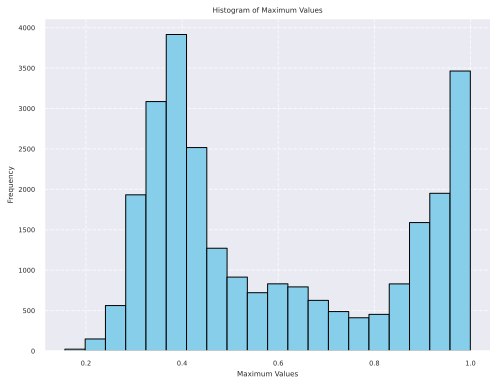

In [30]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(df_histogram['bin_edges'], df_histogram['frequency'], width=np.diff(bin_edges), align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Maximum Values')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [31]:
threshold = 0.62
max_values = y_pred.max(axis=1)
above_threshold_indices = max_values > threshold
X['AI_Program'] = label_encoder.inverse_transform(y_pred.argmax(axis=1))
X.loc[above_threshold_indices, 'Programs'] = label_encoder.inverse_transform(y_pred[above_threshold_indices].argmax(axis=1))
X.loc[~above_threshold_indices, 'Programs'] = "Other"
X['AI_max_Prob']=y_pred.max(axis=1)

In [32]:
# Export DataFrame X to an Excel file
X.to_excel('output.xlsx', index=False)
